## The dataset that can be downloaded from this [Kaggle link](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews#IMDB%20Dataset.csv).

### The file contains 50,000 records and two columns: review and sentiment. The review column contains text for the review and the sentiment column contains sentiment for the review. The sentiment column can have two values i.e. "positive" and "negative" which makes our problem a binary classification problem.

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


## Importing and Analyzing the Dataset



In [0]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")

In [7]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
movie_reviews.isnull()

,review,sentiment
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
49995,False,False
49996,False,False
49997,False,False
49998,False,False


In [9]:
movie_reviews.isnull().values.any()

False

In [10]:
movie_reviews.shape

(50000, 2)

Let's now take a look at any one of the reviews so that we have an idea about the text that we are going to process.

In [11]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

Let's see the distribution of positive and negative sentiments in our dataset.

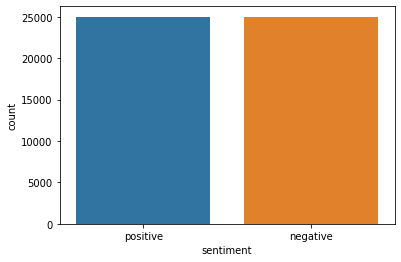

In [13]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews);

## Data Preprocessing

We saw that our dataset contained punctuations and HTML tags. In this section we will define a function that takes a text string as a parameter and then performs preprocessing on the string to remove special characters and HTML tags from the string.

The remove_tags function simply replaces anything between opening and closing <> with an empty space.

In [0]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

Next, in the preprocess_text function, everything is removed except capital and small English letters, which results in single characters that make no sense. For instance, when you remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s"

Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

In [0]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

Next, we will preprocess our reviews and will store them in a new list as shown below:

In [0]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [17]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

Next, we need to convert our labels into digits. Since we only have two labels in the output i.e. "positive" and "negative". We can simply convert them into integers by replacing "positive" with digit 1 and negative with digit 0 as shown below:

In [0]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [19]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Let's now write the script for our embedding layer. The embedding layer converts our textual data into numeric data and is used as the first layer for the deep learning models in Keras.

## Preparing the Embedding Layer

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [0]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [34]:
X_train

array([[  17,   23,    4, ...,  198,  345, 3812],
       [1069,  100,   31, ...,   82,   99,    6],
       [  18,   31,  481, ...,    2,  695,   58],
       ...,
       [  91,  888,   73, ..., 1607,    2,  584],
       [ 224,    3,    8, ...,  241,   99,  122],
       [ 701, 2139,  199, ...,   67,   69, 1946]], dtype=int32)

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

Finally, we will create an embedding matrix where each row number will correspond to the index of the word in the corpus. The matrix will have 100 columns where each column will contain the GloVe word embeddings for the words in our corpus.

In [0]:
embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Text Classification with Simple Neural Network

Since we are not training our own embeddings and using the GloVe embedding, we set trainable to False and in the weights attribute we pass our own embedding matrix.

In [37]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            4627350   
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2501      
Total params: 4,629,851
Trainable params: 2,501
Non-trainable params: 4,627,350
_________________________________________________________________
None


In [39]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)



Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 1s 29us/step - loss: 0.6421 - acc: 0.6338 - val_loss: 0.5937 - val_acc: 0.6781
Epoch 2/6
32000/32000 [==============================] - 1s 18us/step - loss: 0.5770 - acc: 0.6984 - val_loss: 0.5817 - val_acc: 0.6981
Epoch 3/6
32000/32000 [==============================] - 1s 18us/step - loss: 0.5623 - acc: 0.7108 - val_loss: 0.5768 - val_acc: 0.7030
Epoch 4/6
32000/32000 [==============================] - 1s 18us/step - loss: 0.5549 - acc: 0.7147 - val_loss: 0.5781 - val_acc: 0.7013
Epoch 5/6
32000/32000 [==============================] - 1s 18us/step - loss: 0.5482 - acc: 0.7203 - val_loss: 0.5763 - val_acc: 0.7034
Epoch 6/6
32000/32000 [==============================] - 1s 18us/step - loss: 0.5452 - acc: 0.7240 - val_loss: 0.5881 - val_acc: 0.6943


In [47]:
history.history

{'acc': [0.63378125, 0.69840625, 0.7108125, 0.7146875, 0.7203125, 0.72396875],
 'loss': [0.6421089537143707,
  0.5770049852132797,
  0.562308390378952,
  0.5549121404886246,
  0.548202110171318,
  0.545186646938324],
 'val_acc': [0.678125, 0.698125, 0.703, 0.70125, 0.703375, 0.69425],
 'val_loss': [0.5937468852996827,
  0.5816618046760559,
  0.5768240218162537,
  0.5781215109825134,
  0.5762796704769134,
  0.5880850572586059]}

In [40]:
score = model.evaluate(X_test, y_test, verbose=1)

10000/10000 [==============================] - 0s 29us/step


In [41]:
score

[0.5878037132263184, 0.6923]

In [43]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5878037132263184
Test Accuracy: 0.6923


In [0]:
import matplotlib.pyplot as plt

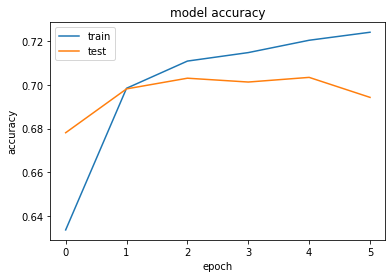

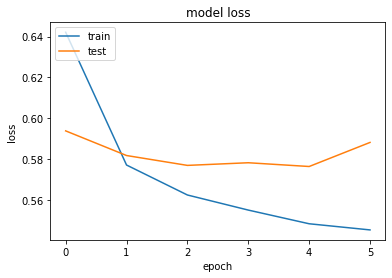

In [48]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Text Classification with a Convolutional Neural Network

Convolutional neural network is a type of network that is primarily used for 2D data classification, such as images. A convolutional network tries to find specific features in an image in the first layer. In the next layers, the initially detected features are joined together to form bigger features. In this way, the whole image is detected.

Convolutional neural networks have been found to work well with text data as well. Though text data is one-dimensional, we can use 1D convolutional neural networks to extract features from our data.

In [0]:
from keras.layers import Conv1D

In [0]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [52]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 50)            4627350   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 128)           32128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 4,659,607
Trainable params: 32,257
Non-trainable params: 4,627,350
_________________________________________________________________
None


You can see that in the above case we don't need to flatten our embedding layer. You can also notice that feature size is now reduced using the pooling layer.

In [53]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 7s 217us/step - loss: 0.5607 - acc: 0.7057 - val_loss: 0.5105 - val_acc: 0.7449
Epoch 2/6
32000/32000 [==============================] - 7s 205us/step - loss: 0.4699 - acc: 0.7771 - val_loss: 0.4732 - val_acc: 0.7684
Epoch 3/6
32000/32000 [==============================] - 7s 205us/step - loss: 0.4345 - acc: 0.7987 - val_loss: 0.4628 - val_acc: 0.7758
Epoch 4/6
32000/32000 [==============================] - 7s 205us/step - loss: 0.4018 - acc: 0.8222 - val_loss: 0.4554 - val_acc: 0.7801
Epoch 5/6
32000/32000 [==============================] - 7s 204us/step - loss: 0.3780 - acc: 0.8343 - val_loss: 0.4765 - val_acc: 0.7658
Epoch 6/6
10000/10000 [==============================] - 1s 90us/step


In [54]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4506824979782105
Test Accuracy: 0.7815


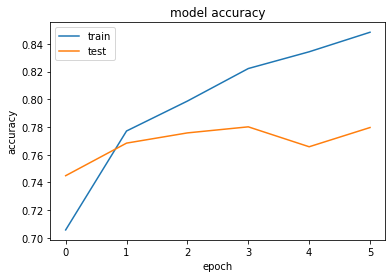

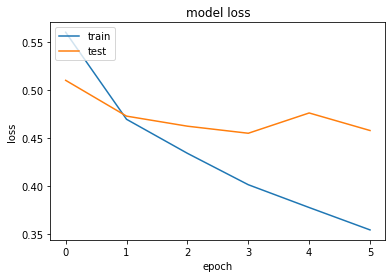

In [55]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

Let's now train our third deep learning model, which is a recurrent neural network, and see if we can get rid of the overfitting.

## Text Classification with Recurrent Neural Network (LSTM)

Recurrent neural network is a type of neural networks that is proven to work well with sequence data. Since text is actually a sequence of words, a recurrent neural network is an automatic choice to solve text-related problems. In this section, we will use an LSTM (Long Short Term Memory network) which is a variant of RNN, to solve sentiment classification problem.

In [0]:
from keras.layers import LSTM

In [0]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [99]:
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 50)            4627350   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 4,719,127
Trainable params: 91,777
Non-trainable params: 4,627,350
_________________________________________________________________
None


In [100]:
history = model.fit(X_train, y_train, batch_size=128, epochs=7, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/7
32000/32000 [==============================] - 35s 1ms/step - loss: 0.5806 - acc: 0.6885 - val_loss: 0.5567 - val_acc: 0.7025
Epoch 2/7
32000/32000 [==============================] - 34s 1ms/step - loss: 0.5224 - acc: 0.7393 - val_loss: 0.5086 - val_acc: 0.7468
Epoch 3/7
32000/32000 [==============================] - 34s 1ms/step - loss: 0.4859 - acc: 0.7638 - val_loss: 0.4765 - val_acc: 0.7671
Epoch 4/7
32000/32000 [==============================] - 34s 1ms/step - loss: 0.4634 - acc: 0.7779 - val_loss: 0.4795 - val_acc: 0.7682
Epoch 5/7
32000/32000 [==============================] - 34s 1ms/step - loss: 0.4459 - acc: 0.7879 - val_loss: 0.4658 - val_acc: 0.7721
Epoch 6/7
32000/32000 [==============================] - 34s 1ms/step - loss: 0.4336 - acc: 0.7946 - val_loss: 0.4456 - val_acc: 0.7890
Epoch 7/7
10000/10000 [==============================] - 4s 369us/step


In [103]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4454580801010132
Test Accuracy: 0.7893


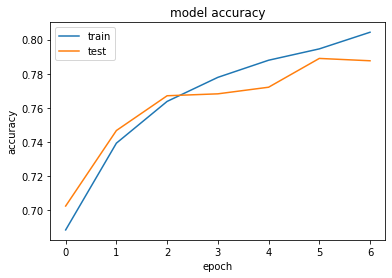

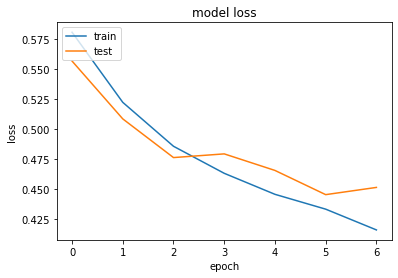

In [104]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Making Predictions on Single Instance

In [111]:
instance = X[31]
print(instance)

 Ardh Satya is one of the finest film ever made in Indian Cinema Directed by the great director Govind Nihalani this one is the most successful Hard Hitting Parallel Cinema which also turned out to be Commercial Success Even today Ardh Satya is an inspiration for all leading directors of India The film tells the Real life Scenario of Mumbai Police of the Unlike any Police of other cities in India Mumbai Police encompasses Different system altogether Govind Nihalani creates very practical Outlay with real life approach of Mumbai Police Environment Amongst various Police officers colleagues the film describes the story of Anand Velankar young hot blooded Cop coming from poor family His father is harsh Police Constable Anand himself suffers from his father ideologies incidences of his father Atrocities on his mother Anand approach towards immediate action against crime is an inert craving for his own Job satisfaction The film is here revolved in Plot wherein Anand constant efforts against

In [112]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.846684]], dtype=float32)